In [1]:
from __future__ import print_function
import numpy as np
import scipy.io as sio
import pandas as pd
from sklearn.metrics import mean_squared_error

np.random.seed(1333)  # for reproducibility

# from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
# input image dimensions
img_rows, img_cols = 128, 128
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

# the data, shuffled and split between train and test sets
WB=sio.loadmat('sandstone_data.mat')['Data']
Y_data = sio.loadmat('sandstone_data.mat')['L']
Y_data = (Y_data-min(Y_data))/(max(Y_data)-min(Y_data))
X_data = np.reshape(WB,(768,1,img_rows,img_cols))
X_train = X_data[0:720];# X_test=X_data[720:768]
Y_train = Y_data[0:720];# Y_test=Y_data[720:768]
X_val = X_data[720:768]
Y_val = Y_data[720:768]

WB1 = sio.loadmat('test_sandstone_data.mat')['Data']
X_test = np.reshape(WB1, (240, 1, img_rows, img_cols))
Y_test = sio.loadmat('test_sandstone_data.mat')['L']
Y_test = (Y_test-min(Y_test))/(max(Y_test) - min(Y_test))


if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_val = X_val.reshape(X_val.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validate samples')
print(X_test.shape[0], 'test samples')

X_train shape: (720, 128, 128, 1)
720 train samples
48 validate samples
240 test samples


In [3]:
# CNN follow vgg16 structure...
# Because the pictrue size is 128, the feture number might need to reduce....

model = Sequential()

#block 1
model.add(Convolution2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
#block 2
model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
#block 3
model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
#block 4
model.add(Convolution2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
#block 5
model.add(Convolution2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

"""
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
# model.add(Dropout(0.25))
"""

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [5]:
model.fit(X_train, Y_train, batch_size=40, epochs=120, verbose=1, validation_data=(X_val, Y_val))

Train on 720 samples, validate on 48 samples
Epoch 1/120
720/720 [==============================] - 110s - loss: 0.1143 - mean_squared_error: 0.1143 - val_loss: 0.0458 - val_mean_squared_error: 0.0458
Epoch 2/120
720/720 [==============================] - 100s - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 3/120
720/720 [==============================] - 93s - loss: 0.0273 - mean_squared_error: 0.0273 - val_loss: 0.0443 - val_mean_squared_error: 0.0443
Epoch 4/120
720/720 [==============================] - 94s - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 5/120
720/720 [==============================] - 96s - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 6/120
720/720 [==============================] - 96s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 7/120
720/720 [==

720/720 [==============================] - 96s - loss: 4.9742e-04 - mean_squared_error: 4.9742e-04 - val_loss: 3.0595e-04 - val_mean_squared_error: 3.0595e-04
Epoch 52/120
720/720 [==============================] - 98s - loss: 2.5627e-04 - mean_squared_error: 2.5627e-04 - val_loss: 2.9267e-04 - val_mean_squared_error: 2.9267e-04
Epoch 53/120
720/720 [==============================] - 99s - loss: 2.9346e-04 - mean_squared_error: 2.9346e-04 - val_loss: 2.0498e-04 - val_mean_squared_error: 2.0498e-04
Epoch 54/120
720/720 [==============================] - 102s - loss: 4.3035e-04 - mean_squared_error: 4.3035e-04 - val_loss: 9.4534e-04 - val_mean_squared_error: 9.4534e-04
Epoch 55/120
720/720 [==============================] - 108s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 56/120
720/720 [==============================] - 99s - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 57/12

720/720 [==============================] - 93s - loss: 1.1457e-04 - mean_squared_error: 1.1457e-04 - val_loss: 1.6129e-04 - val_mean_squared_error: 1.6129e-04
Epoch 101/120
720/720 [==============================] - 98s - loss: 1.6163e-04 - mean_squared_error: 1.6163e-04 - val_loss: 1.7552e-04 - val_mean_squared_error: 1.7552e-04
Epoch 102/120
720/720 [==============================] - 112s - loss: 1.2449e-04 - mean_squared_error: 1.2449e-04 - val_loss: 1.6091e-04 - val_mean_squared_error: 1.6091e-04
Epoch 103/120
720/720 [==============================] - 111s - loss: 1.9733e-04 - mean_squared_error: 1.9733e-04 - val_loss: 1.9391e-04 - val_mean_squared_error: 1.9391e-04
Epoch 104/120
720/720 [==============================] - 98s - loss: 1.3750e-04 - mean_squared_error: 1.3750e-04 - val_loss: 3.4599e-04 - val_mean_squared_error: 3.4599e-04
Epoch 105/120
720/720 [==============================] - 99s - loss: 2.5391e-04 - mean_squared_error: 2.5391e-04 - val_loss: 1.8122e-04 - val_mean_

0.00688798978224


/home/conebeam/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in divide


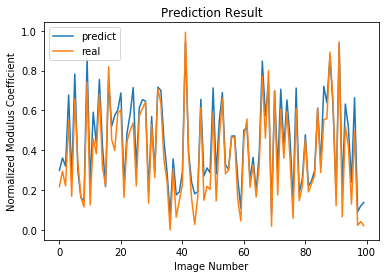

In [6]:
x=[]
for i in range(100):
    x.append(i)

pred=model.predict(X_test)
print(mean_squared_error(Y_test, pred))

fig1 = plt.figure()
ax1=fig1.add_subplot(1,1,1)

ax1.plot(x,pred[0:100], label='predict')
ax1.plot(x,Y_test[0:100],label='real')
plt.legend()
ax1.set_title('Prediction Result')
ax1.set_xlabel('Image Number')
ax1.set_ylabel('Normalized Modulus Coefficient')

se = np.zeros([240])
for i in range(240):
    se[i] = (pred[i]-Y_test[i])/Y_test[i]

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
activation_3 (Activation)    (None, 64, 64, 64)        0         
__________